In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/


In [ ]:
!kaggle datasets download -d andrewmvd/lung-and-colon-cancer-histopathological-images

Dataset URL: https://www.kaggle.com/datasets/andrewmvd/lung-and-colon-cancer-histopathological-images
License(s): CC-BY-SA-4.0
 99% 1.75G/1.76G [00:15<00:00, 255MB/s]
100% 1.76G/1.76G [00:15<00:00, 119MB/s]


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/lung-and-colon-cancer-histopathological-images.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
DATADIR = '/content/Lung Cancer' #base directory
CATEGORIES = ['lung_adenocarcinomas', 'lung_normal', 'lung_squamous_cell_carcinomas']

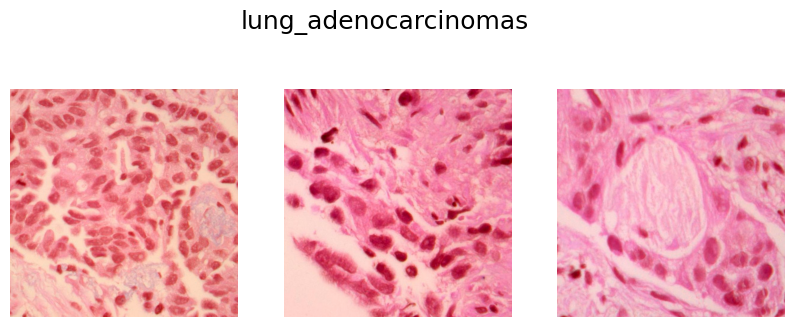

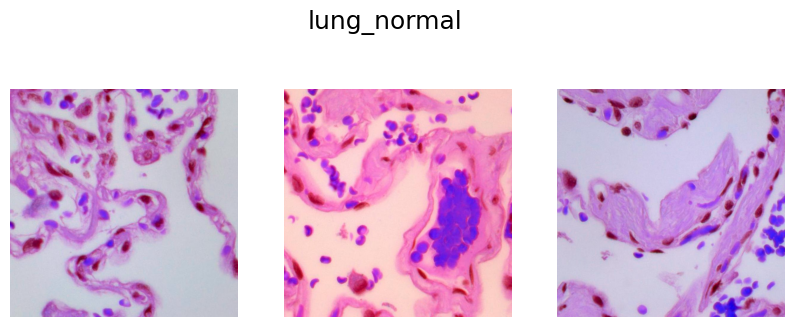

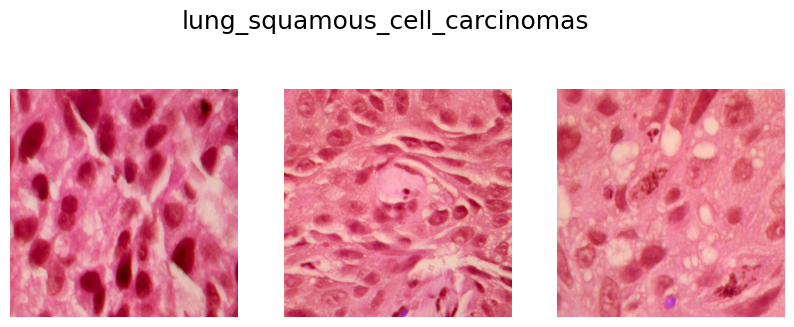

In [ ]:

import os
import matplotlib.pyplot as plt
import cv2
import numpy as np
for category in CATEGORIES:
  path = os.path.join(DATADIR, category) #constructing the path
  images = os.listdir(path)

  fig, ax = plt.subplots(1, 3, figsize=(10, 4))
  fig.suptitle(f'{category}', fontsize=18)

  for i in range(3):
    img_name = images[np.random.randint(0, len(images))]
    img_path = os.path.join(path, img_name)
    img_array = cv2.imread(img_path)

    ax[i].imshow(img_array)
    ax[i].axis('off')


In [ ]:
img_array.shape

(768, 768, 3)

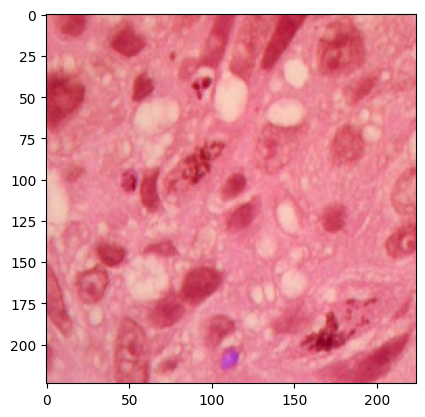

In [ ]:
IMG_SIZE = 224
new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
plt.imshow(new_array)

In [ ]:
new_array.shape

(224, 224, 3)

In [ ]:
#create training data
training_data = []
def create_train_data():
  for category in CATEGORIES:
    path = os.path.join(DATADIR, category) #constructing the path
    labels = CATEGORIES.index(category)
    for img in os.listdir(path):
      try:
        img_array =cv2.imread(os.path.join(path, img))
        new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
        training_data.append([new_array, labels])
      except Exception as e:
        pass
create_train_data()

In [ ]:
len(training_data)

15000

In [ ]:
X = []
y = []

for features, labels in training_data:
  X.append(features)
  y.append(labels)

In [ ]:
X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
y = np.array(y)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [ ]:
print(f'X_train length : {X_train.shape[0]}, X_train Image Size : {X_train.shape[1:3]}, X_train Channel Dimension : {X_train.shape[3]}')
print(f'X_test length : {X_test.shape[0]}, X_test Image Size : {X_test.shape[1:3]}, X_test Channel Dimension : {X_test.shape[3]}')

X_train length : 12000, X_train Image Size : (224, 224), X_train Channel Dimension : 3
X_test length : 3000, X_test Image Size : (224, 224), X_test Channel Dimension : 3


In [ ]:
#VGG Model Building
import tensorflow as tf
from tensorflow import keras
from keras.applications import vgg16

In [ ]:
vgg = vgg16.VGG16(weights = 'imagenet', include_top = False, input_shape = (IMG_SIZE, IMG_SIZE, 3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
# FREEZING THE LAYERS
for layer in vgg.layers:
  layer.trainable = False

In [ ]:
# adding top layers
model = keras.Sequential([
    vgg,
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dense(1024, activation = 'relu'),
    keras.layers.Dense(512, activation = 'relu'),
    keras.layers.Dense(3, activation = 'softmax'),
])

In [ ]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
model.fit(X_train, y_train, epochs = 5)

Epoch 1/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 74s 157ms/step - accuracy: 0.9040 - loss: 0.4878
Epoch 2/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 62s 165ms/step - accuracy: 0.9685 - loss: 0.0852
Epoch 3/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 61s 164ms/step - accuracy: 0.9847 - loss: 0.0413
Epoch 4/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 83s 166ms/step - accuracy: 0.9858 - loss: 0.0402
Epoch 5/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 82s 166ms/step - accuracy: 0.9901 - loss: 0.0247


In [ ]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Model Accuracy : {accuracy * 100}')

94/94 ━━━━━━━━━━━━━━━━━━━━ 24s 251ms/step - accuracy: 0.9825 - loss: 0.0493
Model Accuracy : 98.4666645526886


In [ ]:
pred = np.argmax(model.predict(X_test), axis = -1)

94/94 ━━━━━━━━━━━━━━━━━━━━ 16s 167ms/step


In [ ]:
pred


array([2, 1, 2, ..., 2, 2, 2])

In [ ]:
y_test[:5]

array([2, 1, 2, 0, 1])

In [ ]:
pred[:5]

array([2, 1, 2, 0, 1])

              precision    recall  f1-score   support

           0       0.99      0.96      0.98      1037
           1       1.00      1.00      1.00       970
           2       0.97      0.99      0.98       993

    accuracy                           0.98      3000
   macro avg       0.98      0.99      0.98      3000
weighted avg       0.98      0.98      0.98      3000



Text(50.722222222222214, 0.5, 'Actual Labels')

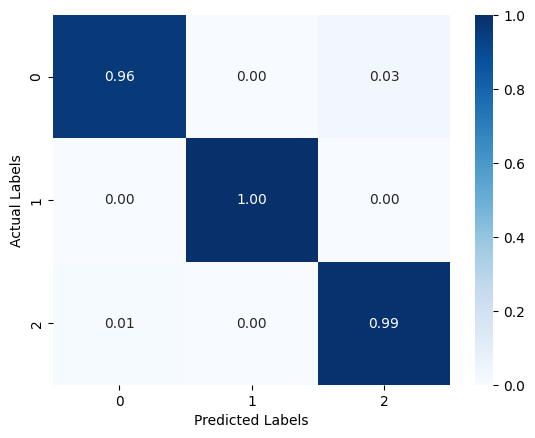

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, pred))
cm = confusion_matrix(y_test, pred, normalize = 'true')
import seaborn as sns
sns.heatmap(cm, annot = True, cmap = 'Blues', fmt = '.2f')
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')